cluster dei rifugi: 
- caratteristiche territoriali (es. altitudine, gruppi rocciosi/idrici, ..) 
- vicinanza (distanza) tra rifugi
- cluster ranking rifugi → per individuare gruppi di performance e vedere se e come cambiano (quali rifugi cambiano classi)

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
from rasterio.plot import show
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from tabulate import tabulate
import os

import warnings
warnings.simplefilter("ignore")


# Territorial Clustering
Cluster based on topographic characteristics: 
- altitude, slope, aspect
- connection to trail network, roads, cableways
- water potential ?
- corpi idrici sotterranei (gruppo geologico) ?

In [2]:
# Load DEM raster
dem_path = "../data/terrain/tinitaly_dem50m.tif"
dem = rasterio.open(dem_path)

# Load slope raster
slope_path = "../data/terrain/tinitaly_slope50m.tif"
slope_raster = rasterio.open(slope_path)

# Load huts GeoDataFrame
huts = gpd.read_file("../data/huts/huts_points.geojson")
huts.to_crs(dem.crs, inplace=True)

In [3]:
## Extract elevation & slope
hut_coords = [(geom.x, geom.y) for geom in huts.geometry]

elevation = [val[0] for val in sample_gen(dem, hut_coords)]
slope = [val[0] for val in sample_gen(slope_raster, hut_coords)]

huts['elevation'] = elevation
huts['slope'] = slope

In [4]:
# # Accessibility: already extracted in mcdm_analysis.ipynb
# huts_criteria = gpd.read_parquet('../data/alternatives_unfiltered.parquet')
# huts_criteria.to_crs(dem.crs, inplace=True)
# huts_criteria.columns

# selected_cols = ['standard_name', 'supply_aerialway', 'supply_helicopter', 'supply_road', 'lift_ids_within_500m',
#        'lift_ids_within_2300m', 'car_access', 'arrival_trails']
# huts = huts.merge(huts_criteria[selected_cols], on='standard_name', how='left')

# # Extract data for lifts and number of trails
# if 'num_trails' not in huts.columns:
#     huts['num_trails'] = None
    
# for idx, row in huts.iterrows():
#     huts.at[idx, 'lift_500m'] = row['lift_ids_within_500m'] is not None
#     huts.at[idx, 'lift_2300m'] = row['lift_ids_within_2300m'] is not None

#     if row['arrival_trails'] is not None and len(row['arrival_trails']) > 0:
#         huts.at[idx, 'num_trails'] = len(row['arrival_trails'])

# huts.drop(columns=['lift_ids_within_500m', 'lift_ids_within_2300m'], inplace=True)
# huts.head(5)

In [5]:
## Add CR_WA_01 (quantitative water source)
huts_qnt = gpd.read_parquet("../data/alternatives_qnt.parquet")
huts_qnt.to_crs(dem.crs, inplace=True)

huts = huts.merge(huts_qnt[['standard_name', 'CR_WA_01']], on='standard_name', how='left')

In [6]:
## Add hydrogeological group ('comp_idrog') for each hut
# limestone (1), magmatic (2), floodvalley (3)
hydrogeo = gpd.read_file("../data/water/corpi_sott/cis_pta2022_v.shp")
hydrogeo.to_crs(dem.crs, inplace=True)

# Spatial join: assign hydrogeological area to each hut
huts_with_hydrogeo = gpd.sjoin(huts, hydrogeo, how="left", predicate="within")

# Extract the relevant column
huts['hydrogeo_comp'] = huts_with_hydrogeo['comp_idrog']  
huts.loc[huts['hydrogeo_comp'] == 'Calcari', 'hydrogeo_comp'] = 1 #'limestone'
huts.loc[huts['hydrogeo_comp'] == 'Vulcaniti', 'hydrogeo_comp'] = 2 #'magmatic'
huts.loc[huts['hydrogeo_comp'] == 'Alluvioni vallive', 'hydrogeo_comp'] = 3 #'flood valley'
huts.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,elevation,slope,CR_WA_01,hydrogeo_comp
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,0.0,None,POINT (666584.351 5077095.370),1802.240967,6.714721,3,1
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,0.0,None,POINT (646874.183 5074717.942),2058.592041,8.659462,3,1
2,antermoia,ANTERMOIA,D,Alp,61,2496,0.0,goods,POINT (704489.000 5150499.000),2497.357910,6.731922,2,1
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,0.0,None,POINT (666672.806 5100323.693),594.101807,47.511280,4,1
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,0.0,None,POINT (637133.000 5087416.000),1615.531982,29.171103,3,1


## Feature clustering: K-means
I use k-means to cluster huts based on the features above, which regard topographic characteristics (elevation and slope) and accessibility (for supplying and visitors).

In [7]:
from sklearn.metrics import silhouette_score

# Select relevant features for clustering
features = ['elevation', 'slope', 'CR_WA_01', 'hydrogeo_comp']# 'supply_aerialway', 'supply_helicopter', 
            #'supply_road', 'car_access', 'num_trails', 'lift_500m', 'lift_2300m']
X = huts[features]

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Set up final metrics
inertia_values = [] # sum of squared distances of samples to their closest cluster center
silhouette_scores = [] # how similar each point is to its cluster compared to other clusters
cluster_stats = {}

# Apply K-Means clustering
k_values = range(2,8)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42) 
    huts[f'cluster_kmeans_k{k}'] = kmeans.fit_predict(X_scaled)
    huts[f'cluster_kmeans_k{k}'] = huts[f'cluster_kmeans_k{k}']

    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    # Group by cluster and compute stats
    cluster_stats[f"k{k}"] = huts.groupby(f'cluster_kmeans_k{k}').agg({
        'elevation': ['mean', 'std', 'min', 'max'],
        'slope': ['mean', 'std'],
        'CR_WA_01': ['mean'],
        'hydrogeo_comp': ['mean']
        # 'supply_aerialway': ['sum'],
        # 'supply_helicopter': ['sum'],
        # 'supply_road': ['sum'],
        # 'lift_500m': ['sum'],
        # 'lift_2300m': ['sum'],
        # 'car_access': ['sum'],
        # 'num_trails': ['mean', 'min', 'max']
    })


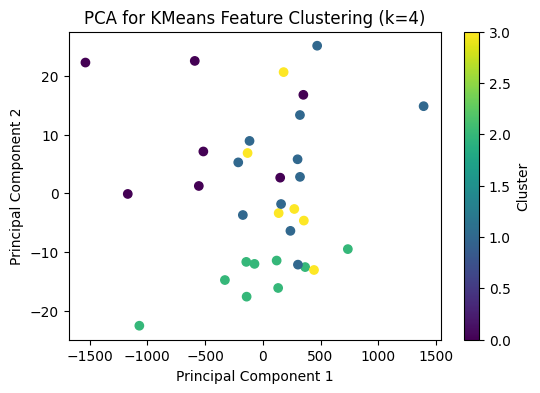

In [8]:
from sklearn.decomposition import PCA
k = 4
# Visualize clustering using PCA for dimensionality reduction (since we have many features)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(huts[features])

# Plot clusters in 2D (first two principal components)
plt.figure(figsize=(6, 4))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=huts[f'cluster_kmeans_k{k}'], cmap='viridis')
plt.title(f'PCA for KMeans Feature Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

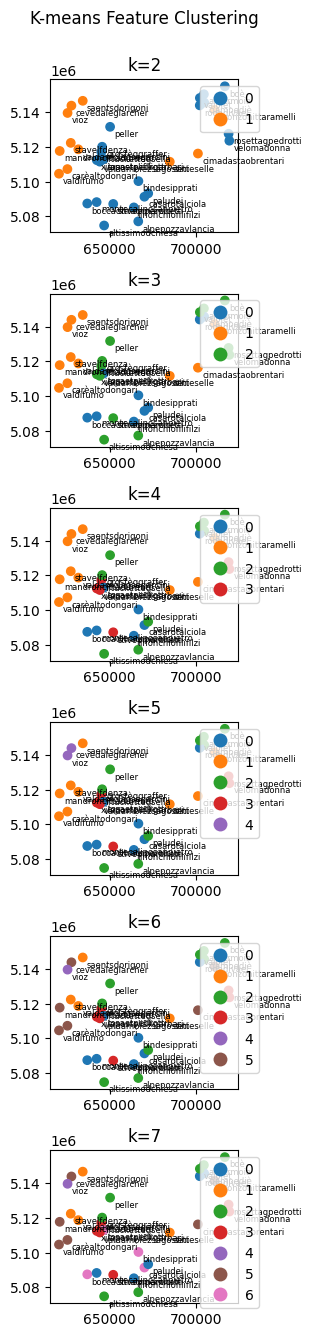

In [9]:
# Plot clusters on map
from matplotlib.colors import ListedColormap, BoundaryNorm
from adjustText import adjust_text

def plot_kmeans_geo(huts, cluster_cols, type:str):
    cluster_colors = {
        "0": "#1f77b4",  # Blue
        "1": "#ff7f0e",  # Orange
        "2": "#2ca02c",  # Green
        "3": "#d62728",  # Red
        "4": "#9467bd",  # Purple
        "5": "#8c564b",  # Brown
        "6": "#e377c2",  # Pink
        "7": "#7f7f7f",  # Gray
        "8": "#bcbd22",  # Olive
        "9": "#17becf"   # Cyan
    }

    # Convert the cluster_colors mapping into a colormap and normalization
    labels = list(cluster_colors.keys())
    cmap = ListedColormap([cluster_colors[label] for label in labels])
    norm = BoundaryNorm(range(len(labels) + 1), cmap.N)

    fig, ax = plt.subplots(len(cluster_cols), 1, figsize=(8, 13))

    for i, col in enumerate(cluster_cols):
        k = col[-1]
        huts[col] = huts[col].astype(str)  # cluster labels are strings

        huts.plot(
            column=col,
            cmap=cmap,
            legend=True,
            legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.15, 1.0)},
            ax=ax[i],
            norm=norm
        )

        for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
            ax[i].annotate(name, xy=(x, y), xytext=(3, -7), textcoords="offset points", fontsize=6)

        ax[i].set_title(f"k={k}")

        huts[col] = huts[col].astype(int) # back to integers

    plt.tight_layout()
    plt.suptitle(f"K-means {type} Clustering", y=1.025)
    plt.show()

cluster_cols = [col for col in huts.columns if 'cluster_kmeans_k' in col]
plot_kmeans_geo(huts, cluster_cols, "Feature")


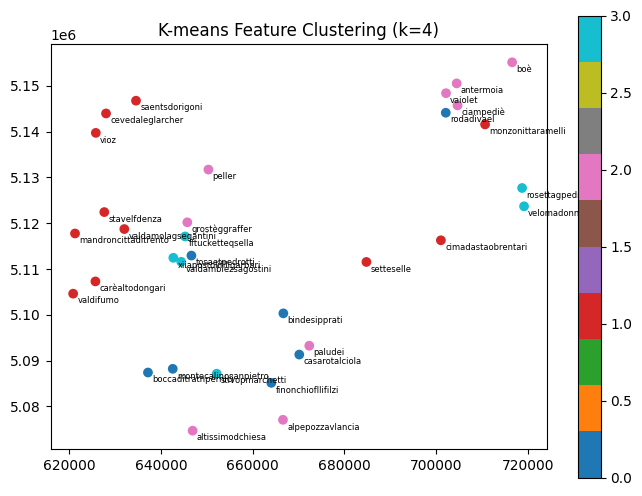

In [10]:
## Plot clusters on map (single column)
col_to_plot = 'cluster_kmeans_k4'

fig, ax = plt.subplots(figsize=(8, 6))
huts.plot(column=col_to_plot, cmap='tab10', legend=True, ax=ax)

for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    ax.annotate(name, xy=(x, y), xytext=(3, -7), textcoords="offset points", fontsize=6)

plt.title(f"K-means Feature Clustering (k={col_to_plot[-1]})")
plt.show()

### Clusters evaluation

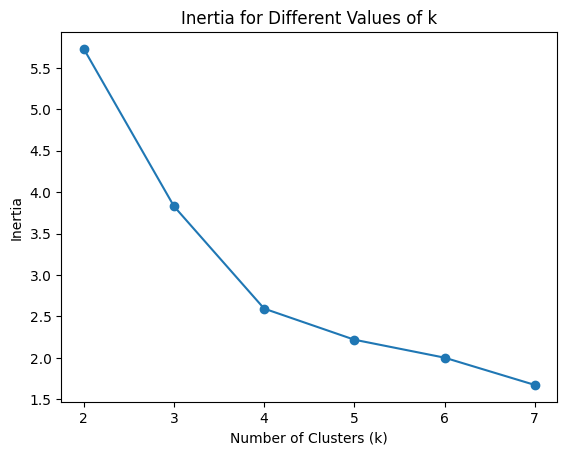

In [11]:
# Inertia (cluster compactness)
# Lower inertia indicates better compactness within clusters but does not necessarily mean 
# the best number of clusters (overfitting is possible). Optimal k may be in an elbow point. 

plt.plot(k_values, inertia_values, marker='o')
#plt.ylim(-1, 1)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Inertia for Different Values of k")
plt.show()


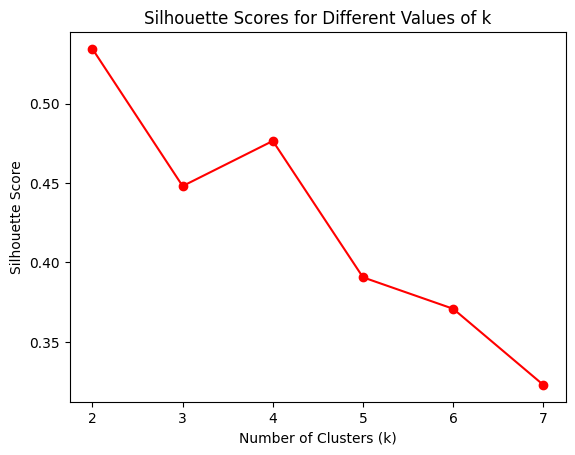

In [12]:
# Silhouette score (cluster separation)
# The score ranges from -1 to 1. A higher score indicates better-defined clusters.

plt.plot(k_values, silhouette_scores, marker='o', color='red')
#plt.ylim(0, 1)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Values of k")
plt.show()

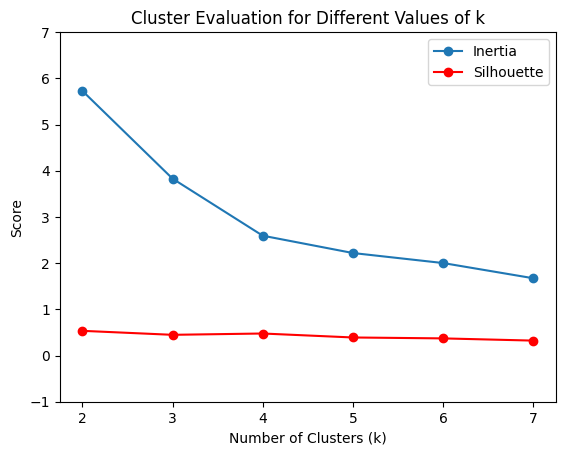

In [13]:
# Plot together
plt.plot(k_values, inertia_values, marker='o', label='Inertia')
plt.plot(k_values, silhouette_scores, marker='o', color='red', label='Silhouette')

plt.ylim(-1, 7)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("Cluster Evaluation for Different Values of k")
plt.legend()
plt.show()

In [14]:
# Check out cluster stats
print(huts['cluster_kmeans_k4'].value_counts())
cluster_stats["k4"]

cluster_kmeans_k4
1    11
2     9
0     7
3     6
Name: count, dtype: int64


elevation                                        \
                          mean         std          min          max   
cluster_kmeans_k4                                                      
0                  1578.720703  666.236145   594.101807  2481.858887   
1                  2404.300537  435.917694  1917.869995  3523.820068   
2                  2086.466553  498.645020  1060.951050  2867.372070   
3                  2340.239990  201.328461  1998.727051  2574.094971   

                       slope             CR_WA_01 hydrogeo_comp  
                        mean        std      mean          mean  
cluster_kmeans_k4                                                
0                  32.525326  10.426784  3.571429           1.0  
1                  24.288061  10.197025  2.090909           2.0  
2                   6.342356   2.851967  2.888889           1.0  
3                  20.384129  12.025316  0.833333           1.0

In [15]:
# List huts for a specific cluster
huts.loc[huts['cluster_kmeans_k4'] == 1]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,elevation,slope,CR_WA_01,hydrogeo_comp,cluster_kmeans_k2,cluster_kmeans_k3,cluster_kmeans_k4,cluster_kmeans_k5,cluster_kmeans_k6,cluster_kmeans_k7
6,carèaltodongari,"CARE' ALTO ""DANTE ONGARI""",D,Alp,74,2450,0.0,goods,POINT (625663.479 5107292.054),2431.916016,25.265144,2,2,1,1,1,1,5,5
8,cevedaleglarcher,"CEVEDALE ""GUIDO LARCHER""",D,Alp,88,2607,0.0,None,POINT (627983.759 5143939.751),2601.485107,44.052845,2,2,1,1,1,4,5,5
10,cimadastaobrentari,"CIMA D'ASTA ""OTTONE BRENTARI""",D,Alp,57,2481,0.0,goods,POINT (701043.977 5116266.942),2452.812988,22.207546,2,2,1,1,1,1,5,5
14,mandroncittàditrento,"MANDRON ""CITTA' DI TRENTO""",D,Alp,89,2445,0.0,both,POINT (621213.949 5117752.751),2452.431885,32.730473,2,2,1,1,1,1,5,5
16,monzonittaramelli,"MONZONI ""TORQUATO TARAMELLI""",C,Alp,16,2043,0.0,None,POINT (710684.696 5141542.381),2015.647949,29.692101,2,2,1,1,1,1,5,5
21,saentsdorigoni,"SAENT ""SILVIO DORIGONI""",D,Alp,80,2436,0.0,None,POINT (634522.416 5146722.339),2435.016113,7.331522,2,2,1,1,1,1,1,1
22,setteselle,SETTE SELLE,D,Alp,25,1977,0.0,None,POINT (684795.802 5111537.366),1957.676025,17.280624,3,2,1,1,1,1,1,1
23,stavelfdenza,"STAVEL ""FRANCESCO DENZA""",D,Alp,80,2298,0.0,goods,POINT (627603.000 5122421.000),2288.843994,18.112942,3,2,1,1,1,1,1,1
28,valdamolagsegantini,"VAL D'AMOLA ""GIOVANNI SEGANTINI""",D,Alp,54,2371,0.0,goods,POINT (631971.611 5118718.043),2369.787109,13.282906,2,2,1,1,1,1,1,1
29,valdifumo,VAL DI FUMO,D,Alp,56,1910,0.0,None,POINT (620805.580 5104617.179),1917.869995,26.346035,2,2,1,1,1,1,5,5


Observations:
- cluster 0 (7 huts): lowest mean elevation (although wide range), limestone component and relying on aqueduct or springs.
- cluster 1 (11 huts): highest mean elevation, only cluster of magmatic component, the majority relies on natural water bodies (streams, lakes), 2 on springs and only one (Vioz) on fusion.
- cluster 2 (9 huts): limestone component, relying on a variety of sources (four on springs, three on water bodies, two on aqueduct) --> mixed group
- cluster 3 (6 huts): high altitudes (but <2500m) with the narrowest range (most homogeneous cluster for elevation), limestone component, all relying on fusion. --> most at risk / urgent class probably.

## Proximity clustering: DBSCAN
Unlike k-means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) doesn't require the number of clusters to be specified beforehand and can identify outliers (noise). It is based on the concept of **core points**, which represent the centers of clusters. A point is considered a core point if it has at least `min_samples` points (including itself) within a distance of `eps`. Clusters are formed by grouping together all points that are connected (density-reachable, either direclty or via other connected points) to at least one core point; points that are not density-reachable from any other point are classified as noise or outliers.

DBSCAN proves as an efficient algorithm for **spatial clustering** to identify groups of huts that are close-by based on their coordinated and elevation. 

In [16]:
# Extract coordinates as np array
coords = np.array(list(huts.geometry.apply(lambda geom: (geom.x, geom.y))))
# combine other features
features = np.hstack([coords, huts[['elevation']].values])

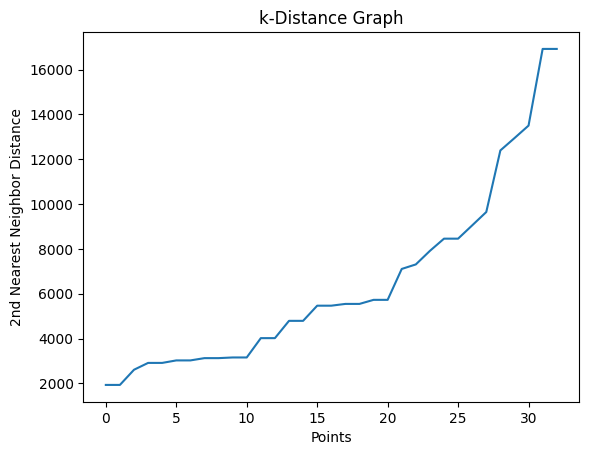

In [17]:
# Tune eps parameter with a k-distance graph: the distance from a point to its k-th nearest neighbor, look for elbow
# Fit Nearest Neighbors
neigh = NearestNeighbors(n_neighbors=2)  # min_samples-1
neigh.fit(coords)
distances, _ = neigh.kneighbors(coords)

# Sort and plot distances
distances = np.sort(distances[:, -1])  # Last column is the k-th neighbor distance
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("2nd Nearest Neighbor Distance")
plt.title("k-Distance Graph")
plt.show()


In [18]:
# DBSCAN parameters
eps = 5000  # Distance threshold in meters (adjust as needed)
min_samples = 2  # Minimum number of huts to form a cluster

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
huts['cluster_dbscan'] = dbscan.fit_predict(features).astype(str)

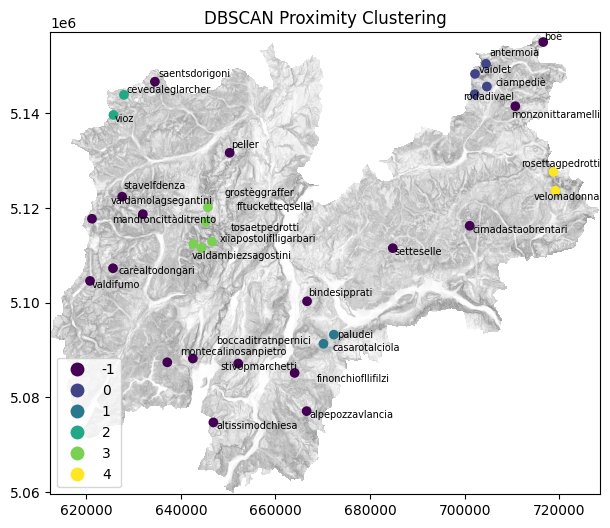

In [19]:
## Plot clusters
fig, ax = plt.subplots(figsize=(8, 6))
show(slope_raster, ax=ax, cmap='binary', alpha=0.6)
huts.plot(column='cluster_dbscan', cmap='viridis', legend=True, ax=ax)

texts = []
for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    texts.append(ax.text(x, y, name, fontsize=7))
adjust_text(texts, ax=ax)

plt.title("DBSCAN Proximity Clustering")
plt.show()

The proximity clusters were produced with eps=5000 (meters) and min_samples=2 to identify possible 'support networks' of close-by huts. I allow small clusters of 2 huts since they are sparse. The results show 5 groups of close huts (considering position and elevation), this should be further investigated by plotting a DEM or slope map underneath. 

In [34]:
clustering_results = huts[['standard_name', 'nome_strut', 'geometry', 'elevation', 'slope', 'CR_WA_01', 'hydrogeo_comp', 'cluster_kmeans_k4', 'cluster_dbscan']]
clustering_results.to_file("../results/feature_cluster_labels.geojson", driver='GeoJSON', crs=huts.crs)

# Ranking Clustering
This section performs clustering of the huts based on the ranks obtained with MCDM analysis in code/mcdm_analysis.ipynb . The objectives are to identify patterns among ranks.

In [20]:
ranks_df = pd.read_csv("../results/rank_df.csv")
# add geometry column for plotting later
ranks_gdf = ranks_df.merge(huts[['standard_name','geometry']], on='standard_name', how='left')
ranks_gdf = gpd.GeoDataFrame(ranks_gdf, geometry='geometry', crs=huts.crs)

configurations_cols = ['TOPSIS_custom', 'PROMETHEE_II_custom', 'VIKOR_custom']

inertia_values = [] 
silhouette_scores = [] 
ranks_cluster_stats = {}

k_values = range(2, 8)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)  
    ranks_gdf[f'cluster_kmeans_k{k}'] = kmeans.fit_predict(ranks_gdf[configurations_cols])
    # metrics
    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(ranks_gdf[configurations_cols], kmeans.labels_)
    silhouette_scores.append(sil_score)
    # cluster stats
    ranks_cluster_stats[f"k{k}"] = ranks_gdf.groupby(f'cluster_kmeans_k{k}')[configurations_cols].agg(['mean', 'std', 'min', 'max'])

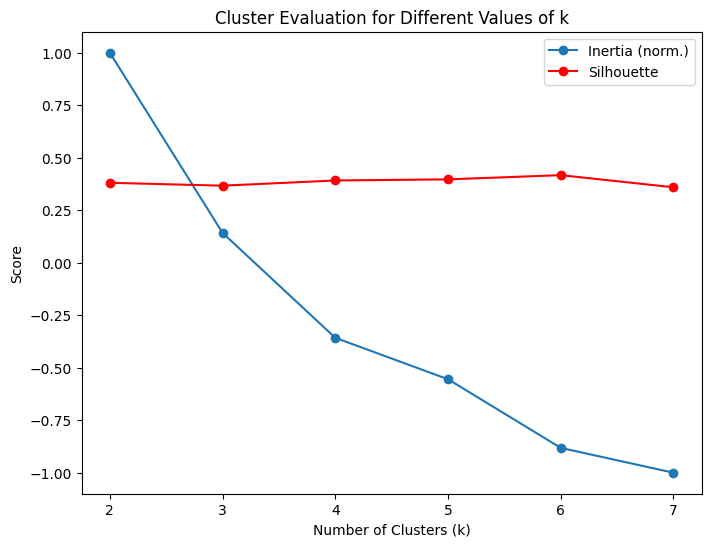

In [21]:
# Plot together (inertia and silhouette scores)

# scale inertia to range -1, 1
plt.figure(figsize=(8,6))
scaled_inertia_values = [-1 + (1 - -1) * (x - min(inertia_values)) / (max(inertia_values) - min(inertia_values)) for x in inertia_values]
plt.plot(k_values, scaled_inertia_values, marker='o', label='Inertia (norm.)') # (compact) the lower, the better
plt.plot(k_values, silhouette_scores, marker='o', color='red', label='Silhouette') #(sep) the higher, the better

#plt.ylim(-1, 7)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("Cluster Evaluation for Different Values of k")
plt.legend()
plt.show()

PCA: it helps to visualize how well the clusters are separated in the high-dimensional space of your rankings (with many features). The distance between points in the plot reflects how similar or different the data points (huts) are in the feature space. If the clusters are well-separated in the PCA plot, it suggests that the clustering has captured meaningful groupings in the data.



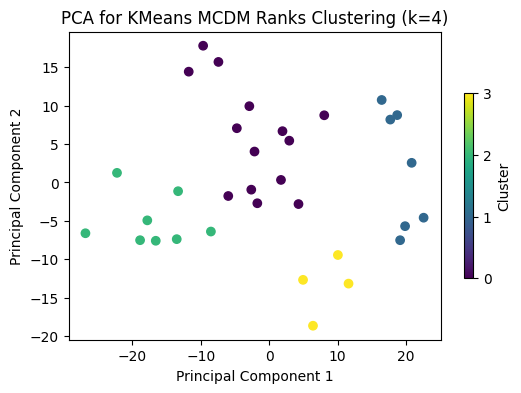

In [22]:
# Visualize clustering using PCA for dimensionality reduction (since we have many features)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(ranks_gdf[configurations_cols])

k = 4

# Plot clusters in 2D (first two principal components)
plt.figure(figsize=(6, 4))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=ranks_gdf[f'cluster_kmeans_k{k}'] ,cmap='viridis')
plt.title(f'PCA for KMeans MCDM Ranks Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster', shrink=0.6, ticks=range(0, 4, 1))
plt.show()

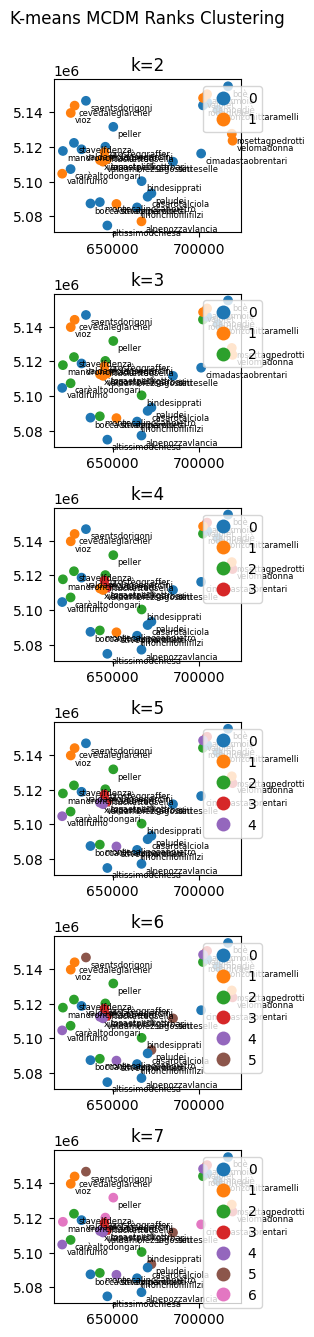

In [23]:
# Plot clusters on map
cluster_cols = [col for col in ranks_gdf.columns if 'cluster_kmeans_k' in col ]
plot_kmeans_geo(ranks_gdf, cluster_cols, "MCDM Ranks")

## Clusters interpretation

In [24]:
ranks_cluster_stats["k4"]

TOPSIS_custom                   PROMETHEE_II_custom  \
                           mean       std min max                mean   
cluster_kmeans_k4                                                       
0                     14.071429  5.928605   4  22           21.642857   
1                     29.571429  2.819997  25  33           25.714286   
2                      6.875000  5.055054   1  15            6.000000   
3                     25.250000  2.217356  23  28            7.500000   

                                    VIKOR_custom                    
                        std min max         mean       std min max  
cluster_kmeans_k4                                                   
0                  5.732594  13  30    14.000000  5.961414   3  22  
1                  6.651172  17  33    28.857143  3.532165  24  33  
2                  3.464102   1  11     7.000000  4.956958   1  15  
3                  4.203173   2  12    26.500000  2.645751  23  29

In [25]:
# Latex table of cluster statistics
df = ranks_cluster_stats["k4"]

selected_cols = [('TOPSIS_custom', 'mean'), ('TOPSIS_custom',  'std'),
                ('PROMETHEE_II_custom', 'mean'), ('PROMETHEE_II_custom',  'std'),
                 ('VIKOR_custom', 'mean'), ('VIKOR_custom', 'std')]
for col in selected_cols: 
    df[col] = round(df[col], 1)

df['allranks_mean'] = round(df[[('TOPSIS_custom', 'mean'),
                ('PROMETHEE_II_custom', 'mean'),
                 ('VIKOR_custom', 'mean')]].mean(axis=1), 1)
df['allranks_std'] = round(df[[('TOPSIS_custom', 'std'),
                    ('PROMETHEE_II_custom', 'std'),
                    ('VIKOR_custom', 'std')]].std(axis=1), 1)

table = tabulate(df, headers='keys', tablefmt='latex')
print(table)

\begin{tabular}{rrrrrrrrrrrrrrr}
\hline
   cluster\_kmeans\_k4 &   ('TOPSIS\_custom', 'mean') &   ('TOPSIS\_custom', 'std') &   ('TOPSIS\_custom', 'min') &   ('TOPSIS\_custom', 'max') &   ('PROMETHEE\_II\_custom', 'mean') &   ('PROMETHEE\_II\_custom', 'std') &   ('PROMETHEE\_II\_custom', 'min') &   ('PROMETHEE\_II\_custom', 'max') &   ('VIKOR\_custom', 'mean') &   ('VIKOR\_custom', 'std') &   ('VIKOR\_custom', 'min') &   ('VIKOR\_custom', 'max') &   ('allranks\_mean', '') &   ('allranks\_std', '') \\
\hline
                   0 &                        14.1 &                        5.9 &                          4 &                         22 &                              21.6 &                              5.7 &                               13 &                               30 &                       14   &                       6   &                         3 &                        22 &                    16.6 &                    0.2 \\
                   1 &                   

### Cluster profiles
What are the characteristics (criteria-based) of the huts in each cluster? 
e.g. Cluster 0: reliable water source, aerialway, generator.

In [26]:
criteria_gdf = gpd.read_parquet("../data/alternatives_qnt.parquet")

# Merge the cluster labels into criteria_gdf
merge_cols = [col for col in ranks_gdf.columns if 'cluster_kmeans_k' in col]
merge_cols.append('standard_name')
criteria_gdf = criteria_gdf.merge(ranks_gdf[merge_cols], on='standard_name')

cluster_criteria_stats = {}
for col in merge_cols[:-1]:
    k = col[-1]
    # Compute summary statistics for each criterion by cluster
    cluster_criteria_stats[f"k{k}"] = criteria_gdf.groupby(f'cluster_kmeans_k{k}').agg({
        'CR_WA_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_WA_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_03': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_04': ['mean', 'median', 'std', 'min', 'max'],
        'CR_SU_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_SU_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_03': ['mean', 'median', 'std', 'min', 'max']
    })


In [ ]:
cluster_criteria_stats["k6"]

CR_WA_01                             CR_WA_02         \
                       mean median       std min max        mean median   
cluster_kmeans_k6                                                         
0                  2.800000    3.0  0.788811   2   4   22.000000   15.0   
1                  1.333333    1.0  0.577350   1   2   60.000000   60.0   
2                  3.125000    3.0  0.834523   2   4  107.000000    1.0   
3                  1.750000    1.5  0.957427   1   3   24.500000   24.0   
4                  1.200000    1.0  0.836660   0   2   26.400000   10.0   
5                  3.000000    3.0  1.000000   2   4    5.666667    0.0   

                                            ...  CR_AC_02                   \
                          std   min    max  ...      mean median       std   
cluster_kmeans_k6                           ...                              
0                   30.840089   0.0  100.0  ...  1.300000    1.0  0.674949   
1                   30.000000  30.0   90.0  ...  1.666667    2.0  0.577350   
2                  280.277414   0.0  800.0  ...  1.750000    2.0  0.707107   
3                   21.000000   0.0   50.0  ...  1.000000    1.0  0.000000   
4                   31.698580   2.0   80.0  ...  1.000000    1.0  0.000000   
5                    9.814955   0.0   17.0  ...  1.333333    1.0  0.577350   

                          CR_AC_03                           
                  min max     mean median       std min max  
cluster_kmeans_k6                                            
0                   1   3    3.200    3.0  0.632456   2   4  
1                   1   2    4.000    4.0  1.000000   3   5  
2                   1   3    2.875    3.0  1.246423   1   4  
3                   1   1    4.000    4.0  0.000000   4   4  
4                   1   1    3.600    4.0  0.547723   3   4  
5                   1   2    3.000    4.0  1.732051   1   4  

[6 rows x 55 columns]

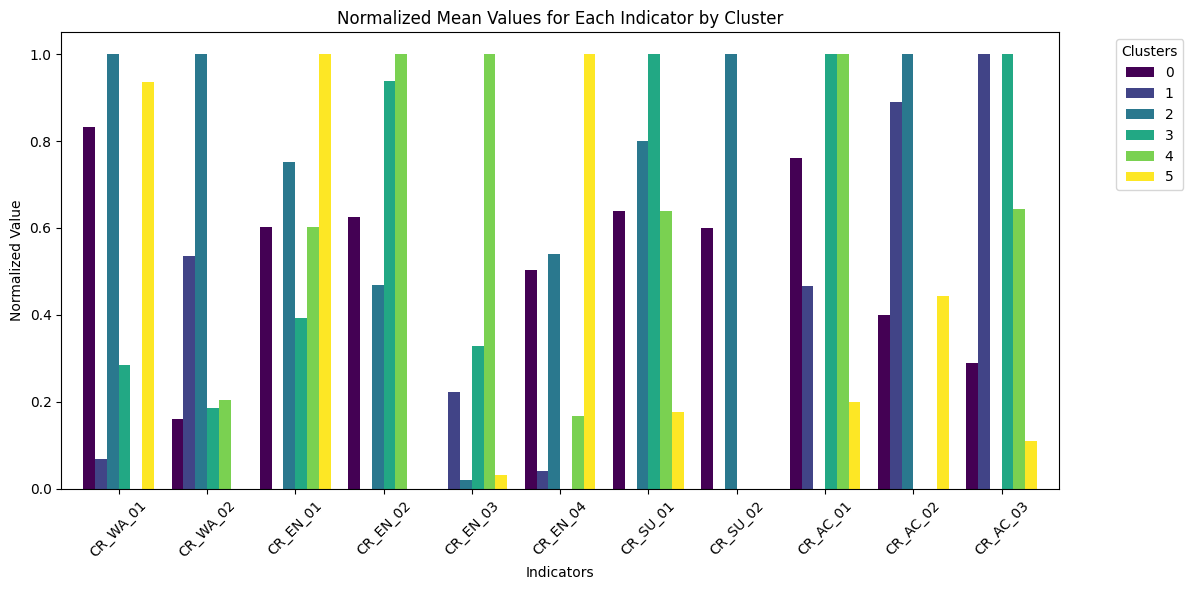

In [28]:
## Plot bar chart of criteria (mean for each cluster)
# Extract mean values and normalize
df = cluster_criteria_stats["k6"]
mean_df = df.xs('mean', level=1, axis=1)  # Select only the "mean" rows
normalized_df = (mean_df - mean_df.min()) / (mean_df.max() - mean_df.min())

# Plot the bar chart
normalized_df.T.plot(kind="bar", figsize=(12, 6), width=0.8, colormap='viridis')
plt.title("Normalized Mean Values for Each Indicator by Cluster")
plt.ylabel("Normalized Value")
plt.xlabel("Indicators")
plt.xticks(rotation=45)
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

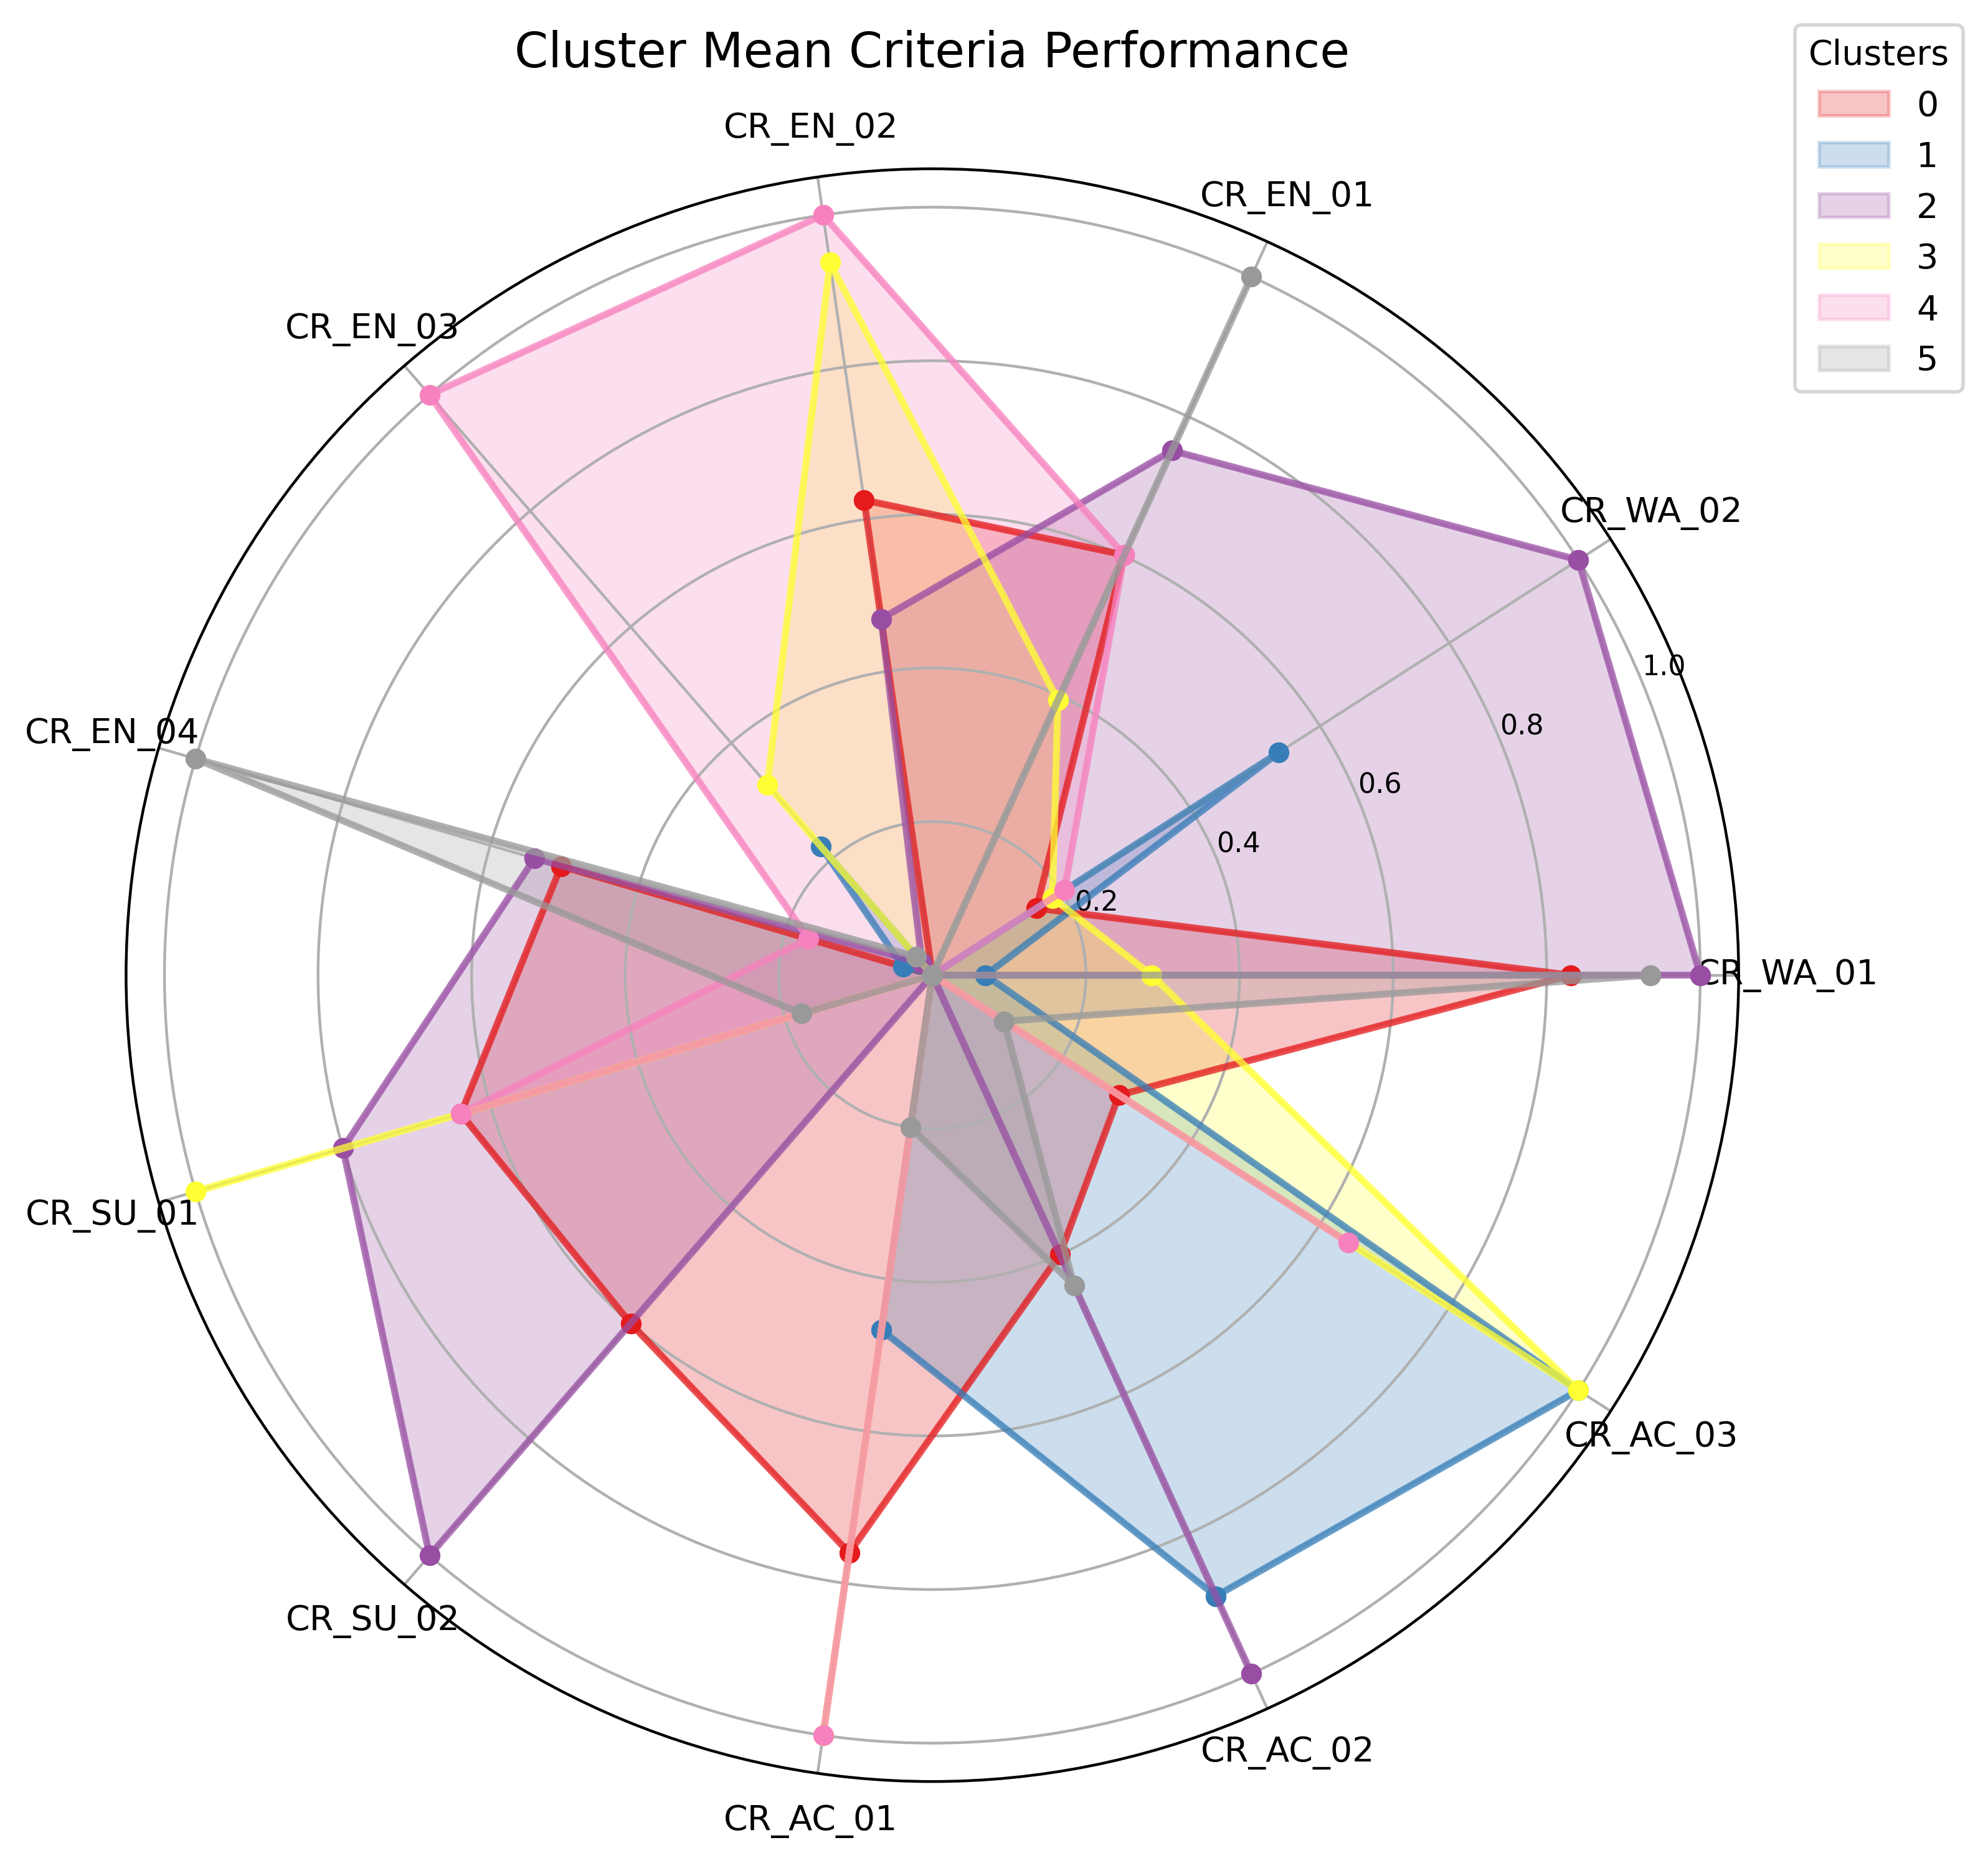

In [29]:
# Generic radar chart function for already formatted df
def plot_radar(df):
    categories = df.columns.tolist()
    num_vars = len(categories)

    # Compute angle for each category
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8), dpi=400, subplot_kw={"projection": "polar"})

    # Define colors for each cluster
    colors = plt.cm.Set1(np.linspace(0, 1, len(df)))

    for i, (idx, row) in enumerate(df.iterrows()):
        values = row.tolist()
        values += values[:1]  # Close the loop
        
        # Plot each cluster
        ax.fill(angles, values, color=colors[i], alpha=0.25, label=idx)
        ax.plot(angles, values, color=colors[i], linewidth=2, alpha=0.75)
        ax.plot(angles, values, 'o', color=colors[i], markersize=5)

    # Add labels and legend
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10, rotation=45)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1), title="Clusters")

    plt.title("Cluster Mean Criteria Performance", size=14, y=1.05)
    plt.tight_layout()
    plt.show()

# Call the function
plot_radar(normalized_df)

In [30]:
## Plot radar charts for each cluster
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

def plot_radar_criteria(alternatives_gdf_qnt, selected_huts:list, cluster_label:int, norm_data=True):
    ''' Plots radar chart showing normalized criteria for huts of the same cluster. '''

    # Select criteria columns and prep data
    criteria_cols = [col for col in alternatives_gdf_qnt.columns if 'CR' in col]
    criteria_cols.append('standard_name')
    data = alternatives_gdf_qnt[criteria_cols]
    data.set_index('standard_name', inplace=True)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Normalize data across each criterion
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)  

    # Prepare angles for each axis, repeat first angle to close the circle
    num_criteria = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_criteria, endpoint=False).tolist()
    angles += angles[:1]

    cmap = plt.get_cmap('viridis', len(selected_huts))

    # Radar plot
    fig, ax = plt.subplots(figsize=(6, 8), dpi=400, subplot_kw=dict(polar=True))
    for i, hut_name in enumerate(selected_huts):
        # Get normalized values for the specific hut
        normalized_hut = normalized_data[data.index == hut_name].flatten()
        normalized_hut = np.concatenate((normalized_hut, [normalized_hut[0]]))  # Close the radar chart loop

        ax.fill(angles, normalized_hut, color=cmap(i), alpha=0.25, label=hut_name)
        ax.plot(angles, normalized_hut, color=cmap(i), linewidth=2, alpha=0.75)
        ax.plot(angles[:-1], normalized_hut[:-1], 'o', color=cmap(i), markersize=5)  # Marker points

    # Set criteria and radius labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(data.columns, fontsize=10)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.grid(color='gray', alpha=0.3)  # grid transparency

    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1), title=f'Huts (Cluster {cluster_label})')
    #plt.title(f'Cluster {cluster_label}', loc='left')
    plt.show()

    return fig

In [31]:
# PLot and optionally save
destination = '/Volumes/TOSHIBA_EXT/DATA SCIENCE UNITN/TESI_RIFUGI/MasterThesisSaraTegoni/Figures/'
for label in ranks_gdf['cluster_kmeans_k6'].unique():
    selected_huts = list(ranks_gdf.loc[ranks_gdf['cluster_kmeans_k6'] == label, 'standard_name']) # list of hut names per cluster
    fig = plot_radar_criteria(criteria_gdf, selected_huts, label)

    filename = f'plot-clusterranks-radar{label}.png'
    #fig.savefig(os.path.join(destination, filename))

    plt.clf()

KeyboardInterrupt: 

In [39]:
label = 5
cluster_names = list(ranks_gdf.loc[ranks_gdf['cluster_kmeans_k6'] == label, 'standard_name'])
cluster_criteria = criteria_gdf.loc[criteria_gdf['standard_name'].isin(cluster_names)]
cluster_criteria

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_SU_02,CR_AC_01,CR_AC_02,CR_AC_03,cluster_kmeans_k2,cluster_kmeans_k3,cluster_kmeans_k4,cluster_kmeans_k5,cluster_kmeans_k6,cluster_kmeans_k7
17,paludei,POINT (672328.564 5093258.751),4,0.0,1.50,2,0.0,4,2.0,2.0,2.5,2,1,0,0,0,0,5,5
21,saentsdorigoni,POINT (634522.416 5146722.339),2,17.0,3.00,1,40.0,3,1.0,2.0,4.0,1,4,0,0,0,0,5,5
22,setteselle,POINT (684795.802 5111537.366),3,0.0,2.33,3,26.5,3,1.0,2.0,4.0,1,4,0,0,0,0,5,5


In [40]:
criteria_gdf_qual = gpd.read_parquet("../data/alternatives_qual_eng.parquet")
criteria_gdf_qual.loc[criteria_gdf_qual['standard_name'].isin(cluster_names)]

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_SU_02,CR_AC_01,CR_AC_02,CR_AC_03
17,paludei,POINT (672328.564 5093258.751),aqueduct,NaN,"public_electricity, gas",2,0.0,public_electricity,vehicle,sewage,"car, trail",2,1
21,saentsdorigoni,POINT (634522.416 5146722.339),stream/lake,17.0,hydroelectric,1,40.0,electric,helicopter,"septic_tank, grid, grease_separator",trail,1,4
22,setteselle,POINT (684795.802 5111537.366),spring,NaN,"photovoltaic, hydroelectric, gas",3,26.5,electric,helicopter,"septic_tank, grid, grease_separator",trail,1,4


In [32]:
ranks_gdf.head(2)

,standard_name,TOPSIS_equal,TOPSIS_entropy,TOPSIS_critic,TOPSIS_custom,VIKOR_equal,VIKOR_entropy,VIKOR_critic,VIKOR_custom,PROMETHEE_II_equal,PROMETHEE_II_entropy,PROMETHEE_II_critic,PROMETHEE_II_custom,geometry,cluster_kmeans_k2,cluster_kmeans_k3,cluster_kmeans_k4,cluster_kmeans_k5,cluster_kmeans_k6,cluster_kmeans_k7
0,montecalinosanpietro,2,8,1,1,3,18,1,1,33,28,31,1,POINT (642540.093 5088221.206),0,2,2,2,2,2
1,carèaltodongari,12,15,9,2,13,22,11,2,19,13,14,10,POINT (625663.479 5107292.054),0,2,2,2,2,2


In [34]:
## Save rank-based clusters
clustering_results = ranks_gdf[['standard_name', 'geometry', 'cluster_kmeans_k2', 'cluster_kmeans_k3', 'cluster_kmeans_k4',	'cluster_kmeans_k5', 'cluster_kmeans_k6', 'cluster_kmeans_k7']]
clustering_results.to_file("../results/ranks_cluster_labels.geojson", driver='GeoJSON', crs=huts.crs)